In [1]:
import pandas as pd
import numpy as np
import math
import os
from path import Path
from datetime import datetime
import matplotlib.pyplot as plt
from haversine import haversine

from utils import *

# Q2

## Read and Orgainze the data into a Dataframe 

### convert all .txt files to dataframe

In [3]:
data_dir = Path('cabspottingdata/')
files = []
taxis = []

# Go through the directory and get the text files and the taxi names
for r, d, f in os.walk(data_dir):
    for file in f:
        if file.endswith(".txt"):
            files.append(os.path.join(r, file))
            taxis.append(file[:-4])
            
files.sort()
taxis.sort()

Create the dataframe

In [4]:
df_list = []

cols = ['latitude', 'longitude', 'occupancy', 'time']

# for (file, taxi) in zip(files, taxis):
for (file, taxi) in zip(files[:10], taxis[:10]):
    temp_df = pd.read_csv(file, sep=' ', names=cols)
    temp_df.insert(0, 'taxi_name', taxi)
    df_list.append(temp_df)

df = pd.concat(df_list)
print(df.shape)

(203659, 5)


In [149]:
# It is also OK to reload data from question 1, which will save time significantly
df = pd.read_pickle('full_data.pkl')
df.shape

(11220058, 6)

In [150]:
df.head()

,latitude,longitude,occupancy,time,taxi_name,local_time
0,37.79826,-122.26613,0,1211034337,new_adkavy,2008-05-17 07:25:37
1,37.79596,-122.26824,0,1211034398,new_adkavy,2008-05-17 07:26:38
2,37.80031,-122.27920,0,1211034467,new_adkavy,2008-05-17 07:27:47
3,37.80219,-122.29588,0,1211034515,new_adkavy,2008-05-17 07:28:35
4,37.81305,-122.30235,0,1211034575,new_adkavy,2008-05-17 07:29:35


## Data preprocess

### normal preprocess

In [14]:
df.reset_index(drop=True, inplace=True)
df.dropna(inplace=True)

In [16]:
# Convert the absolute time to the local time:
df['local_time'] = df['time'].apply(target_tz, tz_name='US/Pacific')
df['local_time'] = df['local_time'].apply(lambda x: x.strftime('%Y-%m-%d %H:%M:%S'))

In [17]:
df.sort_values(by=['taxi_name', 'local_time'], inplace=True, ascending=True)

### Add column of in_out:

In [18]:
occupancy = df['occupancy'].to_list()
in_out = []

for i in range(0, len(occupancy)):
    if i==0:
        in_out.append(occupancy[i])
    else:
        before = occupancy[i-1]
        after = occupancy[i]
        if (before == 0) and (after == 1):
    #         print(before, after, (before == 0) and (after == 1))
            in_out.append('in')
        elif (before == 1) and (after == 0):
    #         print(before, after, (before == 1) and (after == 0))
            in_out.append('out')
        else:
            in_out.append(occupancy[i])
            
df['in_out'] = in_out

### remove outliers

In [151]:
location_df = df[['latitude','longitude']]

Q1 = location_df.quantile(0.005)
Q3 = location_df.quantile(0.995)
IQR = Q3 - Q1
IQR

df = df[~((location_df < (Q1 - 1.5 * IQR)) |(location_df > (Q3 + 1.5 * IQR))).any(axis=1)]
df.reset_index(drop=True, inplace=True)
df.shape

(11219965, 6)

### add "drive_id" column

In [49]:
occupancy = df['occupancy'].to_list()
drive_id = []
idx = 0

for i in range(0, len(occupancy)):
    if i==0:
        drive_id.append(idx)
    else:
        before = occupancy[i-1]
        after = occupancy[i]
        if before == after:
    #         print(before, after, (before == 0) and (after == 1))
            drive_id.append(idx)
        else:
            idx += 1
            drive_id.append(idx)
            
df['drive_id'] = drive_id

In [50]:
df.sample(2)

,latitude,longitude,occupancy,time,taxi_name,local_time,in_out,day,hour,drive_id
9500190,37.77234,-122.45415,1,1212225613,new_oshyon,2008-05-31 02:20:13,1,5,2,785919


### save data

In [56]:
# df.to_pickle('question2_full_data.pkl')
# df_1week.to_excel('week_sample_data.xlsx', index=False, encoding='utf-8')

### Obtain the cluster matrix (Grid)

In [70]:
my_grid = get_passenger_grid(df)

Let's plot in Log scale as the number of data in some clusters is much bigger than others:

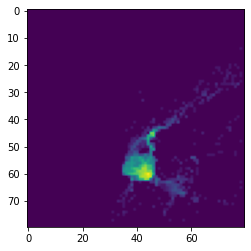

In [71]:
plt.imshow(np.log(np.array(my_grid)+1))
plt.show()

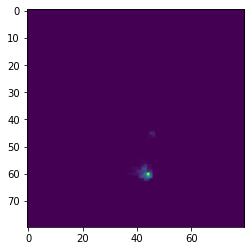

In [72]:
plt.imshow(np.array(my_grid))
plt.show()

### Add the day time / weekday:

Let's first start by creating 2 extra columns:

In [73]:
df['day'] = df['local_time'].apply(get_weekday)

In [74]:
df['hour'] = df['local_time'].apply(get_hour)

In [75]:
df.sample(3)

,latitude,longitude,occupancy,time,taxi_name,local_time,in_out,day,hour,drive_id
1158963,37.78402,-122.47429,0,1212024981,new_amnurgji,2008-05-28 18:36:21,0,2,18,94372
9450855,37.78575,-122.42112,0,1211117674,new_osacmu,2008-05-18 06:34:34,0,6,6,781668
8566575,37.79788,-122.40720,1,1212715398,new_ojvighta,2008-06-05 18:23:18,1,3,18,708073


The previous two steps seem to be a bit time consuming, so let's save the dataframe and load it if needed:

In [76]:
# df.to_pickle('full_data.pkl')

Load if needed:

In [77]:
# Uncomment if you want to load, and not go through the whole processing again:
# df = pd.read_pickle('full_data.pkl')

### How to find the destination:

Let's create a grid containing the locations of these:

In [133]:
# First things first: since the size is very small, we will rely on the coordinates system using the full dataframe
n_rows = 82
n_cols = 102

useful_info = get_bbox_and_size(df, n_rows=n_rows, n_cols=n_cols)

min_lon = useful_info['min_longitude']
max_lon = useful_info['max_longitude']
min_lat = useful_info['min_latitude']
max_lat = useful_info['max_latitude']

row_size = useful_info['row_size']
col_size = useful_info['col_size']

col_size 0.009220891089108875
row_size 0.01133753086419745


In [134]:
width = haversine((min_lat, min_lon),(min_lat, max_lon))
width

82.6151419569606

In [135]:
height = haversine((min_lat, min_lon),(max_lat, min_lon))
height

102.1148899816613

Now suppose that my taxi is at the following coordinates, and at the following day/time:

In [100]:
current_location = (df.iloc[103600]['longitude'], df.iloc[103600]['latitude'])
current_location

(-122.40106, 37.79177)

## samples 1

### current_location

In [101]:
current_location = (-122.44016, 37.77917)
current_day = 0
current_hour = 12

### specify day and hour

In [102]:
local_df = df[(df['day'] == current_day) & (df['hour'] == current_hour) & (df['in_out'] == 'in')]
local_df.reset_index(drop=True, inplace=True)
print(local_df.shape)

(2572, 10)


In [103]:
# Now let's create the grid
my_grid = get_passenger_grid(local_df, n_rows=n_rows, n_cols=n_cols, 
                             min_lon=min_lon, max_lon=max_lon, min_lat=min_lat, max_lat=max_lat)

### Model describtion:
- The further away the cell is from the taxi's current location, the worse it is  (variable $d$, negative)
- The denser the cell is, the better it is (variable $\rho$, positive)
- The highest the probability of taxis around, the worse it is (variable $P_t$, negative)

Let's try to give a score based on this assumption to each cell, and select one with the highest score:
$S = \frac{w_{\rho} \rho}{(1 + P_t) \times w_d d}$

In [122]:
# Let's check all the grids and select one with the highest score
score_grid = np.zeros((n_rows, n_cols))

for r in range(n_rows):
    for c in range(n_cols):
        cell_center_lon = min_lon + col_size * (r + 0.5)
        cell_center_lat = min_lat + row_size * (c + 0.5)
        
        rho = my_grid[r][c]
        if rho != 0:
            d   = get_distance(current_location, (cell_center_lon, cell_center_lat))
            Pt_vals  = get_empty_taxis_around(df, current_day, current_hour, cell_center_lon, cell_center_lat, distance=3)
            if Pt_vals[0] == 0:
                Pt = 0
            else: 
                Pt = Pt_vals[1] / Pt_vals[0]
            print(rho / ((1+Pt) * d))
                
            score_grid[r][c] = rho / ((1+Pt) * d)
            

0.017824028388549084
0.02228483438452582
0.02540028228668599
0.03176736863994118
0.025404177752532935
0.1704066653439065
0.04144358246861329
0.03807491740521445
0.05211586690487013
0.8938803396367949
0.41365612526859113
2.3109279036833437
10.592476721901127
3.1141406774956604
0.1309615341467901
1.4356570691082293
0.12677115490246163
0.2977719851739642
0.32746449594001203
0.06120178448687014
0.11010478987973733
0.14571756266287794
0.11130385210549715
0.36399573144288877
0.32704364373540445
0.7827062419790183
0.05719394745500829
0.11981854489735452
0.5019436667980157
0.20732245234248214
0.08161948288280248
0.11549512320948495
0.3440733686439618
2.400047945552067
0.6946937705804177
0.21942576621022733
1.2920036397431642
0.10079624274510099
0.5211186628428461
0.057984926848343284
4.24852172473371
0.777936498729144
0.6445387131121226
0.3809701830668336
0.306771017226969
0.1686791580430216
0.19607785760254606
0.05802915779410107
0.054057808883511395
0.10322708034043164
0.5547907268335716
1.1

### Get cell index:

In [169]:
ind = np.unravel_index(np.argmax(score_grid, axis=None), score_grid.shape)
ind

(62, 57)

### Result 
The taxi should go to the longitude, latitude defined below:

In [170]:
destination_lon = min_lon + col_size * (ind[0] + 0.5)
destination_lat = min_lat + row_size * (ind[1] + 0.5)
print('destination_lon', destination_lon)
print('destination_lat', destination_lat)

destination_lon -122.3550043069307
destination_lat 37.733558024691355


In [171]:
print('origin_lon', current_location[0])
print('origin_lat', current_location[1])

origin_lon -122.44016
origin_lat 37.77917


## Samples 2

### current_location

In [138]:
current_location = (-122.4064, 37.6471)
current_day = 0
current_hour = 12

### specify day and hour

In [139]:
local_df = df[(df['day'] == current_day) & (df['hour'] == current_hour) & (df['in_out'] == 'in')]
local_df.reset_index(drop=True, inplace=True)
print(local_df.shape)

(2572, 10)


In [140]:
# Now let's create the grid
my_grid = get_passenger_grid(local_df, n_rows=n_rows, n_cols=n_cols, 
                             min_lon=min_lon, max_lon=max_lon, min_lat=min_lat, max_lat=max_lat)

### Model describtion:
- The further away the cell is from the taxi's current location, the worse it is  (variable $d$, negative)
- The denser the cell is, the better it is (variable $\rho$, positive)
- The highest the probability of taxis around, the worse it is (variable $P_t$, negative)

Let's try to give a score based on this assumption to each cell, and select one with the highest score:
$S = \frac{w_{\rho} \rho}{(1 + P_t) \times w_d d}$

In [142]:
# Let's check all the grids and select one with the highest score
score_grid = np.zeros((n_rows, n_cols))

for r in range(n_rows):
    for c in range(n_cols):
        cell_center_lon = min_lon + col_size * (r + 0.5)
        cell_center_lat = min_lat + row_size * (c + 0.5)
        
        rho = my_grid[r][c]
        if rho != 0:
            d   = get_distance(current_location, (cell_center_lon, cell_center_lat))
            Pt_vals  = get_empty_taxis_around(df, current_day, current_hour, cell_center_lon, cell_center_lat, distance=3)
            if Pt_vals[0] == 0:
                Pt = 0
            else: 
                Pt = Pt_vals[1] / Pt_vals[0]
            print(rho / ((1+Pt) * d))
                
            score_grid[r][c] = rho / ((1+Pt) * d)
            

0.017824028388549084
0.02228483438452582
0.02540028228668599
0.03176736863994118
0.025404177752532935
0.1704066653439065
0.04144358246861329
0.03807491740521445
0.05211586690487013
0.8938803396367949
0.41365612526859113
2.3109279036833437
10.592476721901127
3.1141406774956604
0.1309615341467901
1.4356570691082293
0.12677115490246163
0.2977719851739642
0.32746449594001203
0.06120178448687014
0.11010478987973733
0.14571756266287794
0.11130385210549715
0.36399573144288877
0.32704364373540445
0.7827062419790183
0.05719394745500829
0.11981854489735452
0.5019436667980157
0.20732245234248214
0.08161948288280248
0.11549512320948495
0.3440733686439618
2.400047945552067
0.6946937705804177
0.21942576621022733
1.2920036397431642
0.10079624274510099
0.5211186628428461
0.057984926848343284
4.24852172473371
0.777936498729144
0.6445387131121226
0.3809701830668336
0.306771017226969
0.1686791580430216
0.19607785760254606
0.05802915779410107
0.054057808883511395
0.10322708034043164
0.5547907268335716
1.1

### Get cell index:

In [165]:
ind = np.unravel_index(np.argmax(score_grid, axis=None), score_grid.shape)
ind

(63, 75)

### Result 
The taxi should go to the longitude, latitude defined below:

In [166]:
destination_lon = min_lon + col_size * (ind[0] + 0.5)
destination_lat = min_lat + row_size * (ind[1] + 0.5)
print('destination_lon', -122.3882043069307)
print('destination_lat', 37.616258024691355)
# print('destination_lon', destination_lon)
# print('destination_lat', destination_lat)

destination_lon -122.3882043069307
destination_lat 37.616258024691355


In [167]:
print('origin_lon', current_location[0])
print('origin_lat', current_location[1])

origin_lon -122.4064
origin_lat 37.6471


# Clustering for Q3

The dataframe is huge, so let's focus on a single day worth of data (Sunday):

In [25]:
clustering_df = df[(df['in_out'] == 'in') & (df['day'].isin([6]))]

In [26]:
df.shape, clustering_df.shape

((11219965, 9), (83475, 9))

In [27]:
clustering_df.head()

,taxi_name,latitude,longitude,occupancy,time,local_time,in_out,day,hour
1061,new_abboip,37.78461,-122.41138,1,1211094452,2008-05-18 00:07:32,in,6,0
1067,new_abboip,37.78575,-122.42099,1,1211094733,2008-05-18 00:12:13,in,6,0
1076,new_abboip,37.79768,-122.42216,1,1211095152,2008-05-18 00:19:12,in,6,0
1083,new_abboip,37.78483,-122.41950,1,1211095538,2008-05-18 00:25:38,in,6,0
1098,new_abboip,37.75156,-122.44235,1,1211096292,2008-05-18 00:38:12,in,6,0


In [28]:
X, clusterer = cluster_dataframe(clustering_df, eps=0.01, min_samples=5)

In [29]:
labels = clusterer.labels_

In [30]:
# Number of clusters in labels, ignoring noise if present.
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
n_noise = list(labels).count(-1)

In [31]:
print("Estimated number of clusters: %d" % n_clusters)
print("Estimated number of noise points: %d" % n_noise)

Estimated number of clusters: 7
Estimated number of noise points: 111


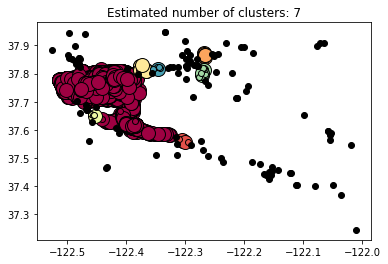

In [39]:
plot_clusters(X, labels, n_clusters, n_noise, clusterer)

Get unique taxis:

In [42]:
a = list(clusterer.fit_predict(X))

In [43]:
labels = list(labels)

In [44]:
def get_unique(df, labels, predictions):
    unique = {}
    for label in labels:
        unique[label] = set()
    for i in range(len(predictions)):
        unique[predictions[i]].add(df.iloc[i]['taxi_name'])
        
    unique_noiseless = {}
    for label in labels:
        if label != -1:
            unique_noiseless[label] = unique[label]
            
    return unique_noiseless

In [45]:
unique_taxis_per_cluster = get_unique(clustering_df, labels, a)

It seems that the conditions of clustering are a bit loose as the vast majority (531 out of 538) belong to the same cluster:

In [50]:
len(unique_taxis_per_cluster[0])

531